<h1 style="text-align: center;">Hotel Bookings Analysis</h1>
<hr>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from datetime import datetime
from pathlib import Path
import requests
import time
from scipy.stats import linregress
import hvplot.pandas

In [2]:
# Read CSVs into dataframes
data_file_df = pd.read_csv("Resources/hotel_bookings.csv")
country_df = pd.read_csv("Resources/countries_codes_and_coordinates.csv")

---
### 1. Clean the countries_codes_and_coordinates.csv.  
- This file has quotation marks which need to be removed

In [3]:
# Define the cleaning function
clean_function = lambda x: x.replace('"', '').strip() if isinstance(x, str) else x

# Apply the cleaning function to each column (Series) in the DataFrame
country_clean_df = country_df.copy()
for col in country_clean_df.columns:
    country_clean_df[col] = country_clean_df[col].map(clean_function)

# Dropping columns 'Alpha-2 code' and 'Numeric code'
country_clean_df = country_clean_df.drop(['Alpha-2 code', 'Numeric code'], axis=1)

# Renaming column 'Country' to 'Country Name'
country_clean_df.rename(columns={'Country': 'Country Name'}, inplace=True)

# Show the first few rows of the cleaned DataFrame
country_clean_df.head()

,Country Name,Alpha-3 code,Latitude (average),Longitude (average)
0,Afghanistan,AFG,33,65
1,Åland Islands,ALA,60.116667,19.9
2,Albania,ALB,41,20
3,Algeria,DZA,28,3
4,American Samoa,ASM,-14.3333,-170


---
### 2. Merge data_file_df and country_df

In [4]:
data_file_df = pd.merge(data_file_df, country_clean_df, how='left', 
                            left_on='country', right_on='Alpha-3 code', suffixes=('', ''))
data_file_df = data_file_df.drop(['Alpha-3 code'], axis=1)
data_file_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Country Name,Latitude (average),Longitude (average)
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,Transient,0.0,0,0,Check-Out,01-07-15,Portugal,39.5,-8
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,Transient,0.0,0,0,Check-Out,01-07-15,Portugal,39.5,-8
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,Transient,75.0,0,0,Check-Out,02-07-15,United Kingdom,54,-2
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,Transient,75.0,0,0,Check-Out,02-07-15,United Kingdom,54,-2
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,Transient,98.0,0,1,Check-Out,03-07-15,United Kingdom,54,-2


---
### 3. Add fields to the datasets

In [5]:
# Add a couple of columns to facilitate the analysis
data_file_df['room_nights'] = (data_file_df['stays_in_weekend_nights'] + data_file_df['stays_in_week_nights'])
data_file_df['amount_spent'] = (data_file_df['room_nights'] * data_file_df['adr'])

In [6]:
data_file_df = data_file_df.dropna(subset=['Country Name'])
data_df = data_file_df
data_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Country Name,Latitude (average),Longitude (average),room_nights,amount_spent
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0.0,0,0,Check-Out,01-07-15,Portugal,39.5,-8,0,0.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0.0,0,0,Check-Out,01-07-15,Portugal,39.5,-8,0,0.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,75.0,0,0,Check-Out,02-07-15,United Kingdom,54,-2,1,75.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,75.0,0,0,Check-Out,02-07-15,United Kingdom,54,-2,1,75.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,98.0,0,1,Check-Out,03-07-15,United Kingdom,54,-2,2,196.0


---
### 4. Identify gaps in the data by date

In [7]:
# Define a categorical type for the months
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
data_file_df["arrival_date_month"] = pd.Categorical(data_file_df["arrival_date_month"], categories=months, ordered=True)

# Group by arrival_date_year and arrival_date_month, then sort
grouped_df = data_file_df.groupby(['arrival_date_year', 'arrival_date_month'], observed=False).size().reset_index(name='counts')
grouped_df = grouped_df.sort_values(by=['arrival_date_year', 'arrival_date_month'])

# Change display settings to show all rows
pd.set_option('display.max_rows', None)

# Display the grouped and sorted DataFrame
print(grouped_df)

    arrival_date_year arrival_date_month  counts
0                2015            January       0
1                2015           February       0
2                2015              March       0
3                2015              April       0
4                2015                May       0
5                2015               June       0
6                2015               July    2750
7                2015             August    3919
8                2015          September    5040
9                2015            October    4907
10               2015           November    2331
11               2015           December    2903
12               2016            January    2222
13               2016           February    3861
14               2016              March    4790
15               2016              April    5418
16               2016                May    5449
17               2016               June    5277
18               2016               July    4485
19               201

---

## 5. Filter Dataset
Based on the above output we decided to filter the dataset based on the following parameters
- Period September 2015 to August 2017 (24 Months)
- Reservation Status being `check out` and `No Show`
- Bookings by country - Top 10

---

In [8]:
## Add a full date and day of week name columns to the data set
# Convert 'arrival_date_month' to its corresponding numeric value
month_mapping = {name: num for num, name in enumerate(calendar.month_name) if num}
data_df.loc[:,'month_num'] = data_df['arrival_date_month'].map(month_mapping)

# Combine 'arrival_date_year', 'arrival_date_month', and 'arrival_date_day_of_month' to a date format
data_df.loc[:,'arrival_date'] = pd.to_datetime(data_df[['arrival_date_year', 'month_num', 'arrival_date_day_of_month']].rename
                                      (columns={'arrival_date_year': 'year', 'month_num': 'month', 
                                                'arrival_date_day_of_month': 'day'}))

# Calculate the day of the week
data_df.loc[:,'day_of_week'] = data_df['arrival_date'].dt.day_name()

In [9]:

# Filter the data based on reservation_status_date and reservation_status
start_date = '2015-09-01'
end_date = '2017-08-31'
filtered_data = data_df[(data_df['arrival_date'] >= start_date) & 
                     (data_df['arrival_date'] <= end_date) & 
                     (data_df['reservation_status'].isin(['Check-Out', 'No-Show']))]

# Group by country and count the reservations
country_counts = filtered_data['Country Name'].value_counts().head(10)

# Filter the original data to include only rows from the top 10 countries
top_countries = country_counts.index.tolist()
top_countries_data = filtered_data[filtered_data['Country Name'].isin(top_countries)]
data_df = top_countries_data

In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59342 entries, 1500 to 120213
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           59342 non-null  object        
 1   is_canceled                     59342 non-null  int64         
 2   lead_time                       59342 non-null  int64         
 3   arrival_date_year               59342 non-null  int64         
 4   arrival_date_month              59342 non-null  category      
 5   arrival_date_week_number        59342 non-null  int64         
 6   arrival_date_day_of_month       59342 non-null  int64         
 7   stays_in_weekend_nights         59342 non-null  int64         
 8   stays_in_week_nights            59342 non-null  int64         
 9   adults                          59342 non-null  int64         
 10  children                        59342 non-null  float64       
 11  bab

---
### 6. Visualize the distribution of bookings by country

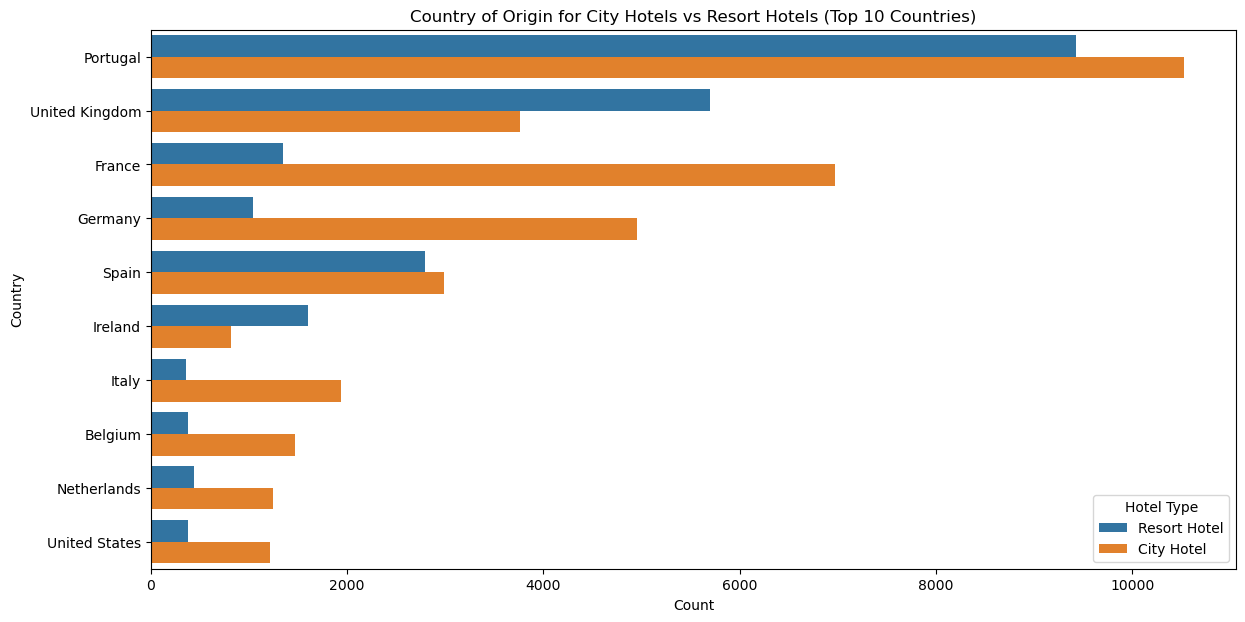

In [11]:

# Plot for country of origin for the top 10 countries
plt.figure(figsize=(14, 7))
sns.countplot(y='Country Name', hue='hotel', data=data_df, order=top_countries)
plt.title('Country of Origin for City Hotels vs Resort Hotels (Top 10 Countries)')
plt.xlabel('Count')
plt.ylabel('Country')
plt.legend(title='Hotel Type')
plt.show()

The bar chart compares the counts of guests staying in city hotels versus resort hotels across the top 10 countries of origin. Here are some key observations:

- **City Hotels** are particularly popular among guests from France, Germany, Italy, Belgium, and the Netherlands.
- **Resort Hotels** are preferred by guests from the UK, Ireland, and Portugal.
- Guests from Spain and the USA are relatively balanced in their preferences, though city hotels have a slight edge in both cases.

---
### 7. ADR Trend over time
#### Average Daily Rate (ADR) vs. Week of the Year

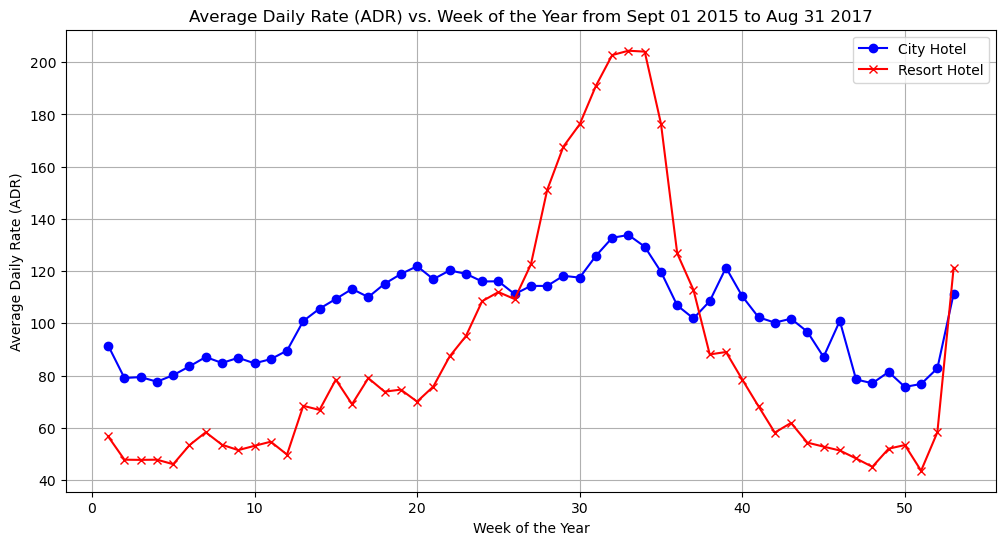

In [12]:
start_date = datetime(2015, 9, 1)
end_date = datetime(2017, 8, 31)


# Create the plot
plt.figure(figsize=(12, 6))# Filter the main DataFrame for check-outs only and make a copy to avoid SettingWithCopyWarning
check_outs_df = data_df[
    (data_df['reservation_status'] == 'Check-Out') &
    (data_df['arrival_date'] >= start_date) &
    (data_df['arrival_date'] <= end_date)
].copy()

# Proceed with filtering for each hotel type
# Filter DataFrame for City Hotel and calculate the mean ADR per week
city_hotel_data = check_outs_df[check_outs_df['hotel'] == 'City Hotel']
city_hotel_weekly_adr = city_hotel_data.groupby('arrival_date_week_number')['adr'].mean()

# Filter DataFrame for Resort Hotel and calculate the mean ADR per week
resort_hotel_data = check_outs_df[check_outs_df['hotel'] == 'Resort Hotel']
resort_hotel_weekly_adr = resort_hotel_data.groupby('arrival_date_week_number')['adr'].mean()


# Plot City Hotel in blue
plt.plot(city_hotel_weekly_adr.index, city_hotel_weekly_adr.values, label='City Hotel', color='blue', marker='o')

# Plot Resort Hotel in red
plt.plot(resort_hotel_weekly_adr.index, resort_hotel_weekly_adr.values, label='Resort Hotel', color='red', marker='x')

# Add titles and labels
plt.title('Average Daily Rate (ADR) vs. Week of the Year from Sept 01 2015 to Aug 31 2017')
plt.xlabel('Week of the Year')
plt.ylabel('Average Daily Rate (ADR)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

The plot shows the Average Daily Rate (ADR) vs. Week of the Year for two types of hotels: City Hotel and Resort Hotel. The data spans from September 1, 2015, to August 31, 2017. Here's a summary of the plot:

### Key Observations:
1. **City Hotel (Blue Line with Dots)**:
   - The ADR for City Hotel starts around 90 and gradually increases, peaking around week 24 at approximately 130.
   - After week 24, the ADR slightly fluctuates but remains relatively stable between 110 and 130 until week 40.
   - From week 40 onwards, the ADR gradually decreases, hitting the lowest point just below 100 around week 50, before slightly increasing again.

2. **Resort Hotel (Red Line with Crosses)**:
   - The ADR for Resort Hotel starts lower than City Hotel, around 60, and shows more significant fluctuations.
   - A noticeable peak occurs around week 32, where the ADR rises sharply to over 200, indicating a high season for the Resort Hotel.
   - After week 32, the ADR sharply decreases, hitting a low around 40 in the following weeks.
   - There is a slight increase towards the end of the year, with ADR rising back to around 60 by week 52.

### Overall Trends:
- **City Hotel**: Shows a more stable ADR with a gradual increase and minor fluctuations throughout the year.
- **Resort Hotel**: Exhibits more significant seasonal variations, with a sharp peak during the middle of the year and a noticeable drop towards the end of the year.

### Conclusion:
- The ADR for City Hotel is generally higher and more stable compared to the Resort Hotel.
- Resort Hotel experiences a high peak in ADR around the middle of the year, likely due to seasonal demand, followed by a sharp decline.

These trends provide insights into the pricing strategies and demand patterns for the two types of hotels over the year.

---
### 8. Total amount spent by country of origin at 
City Hotel and Resort Hotel from September 1, 2015, to August 31, 2017

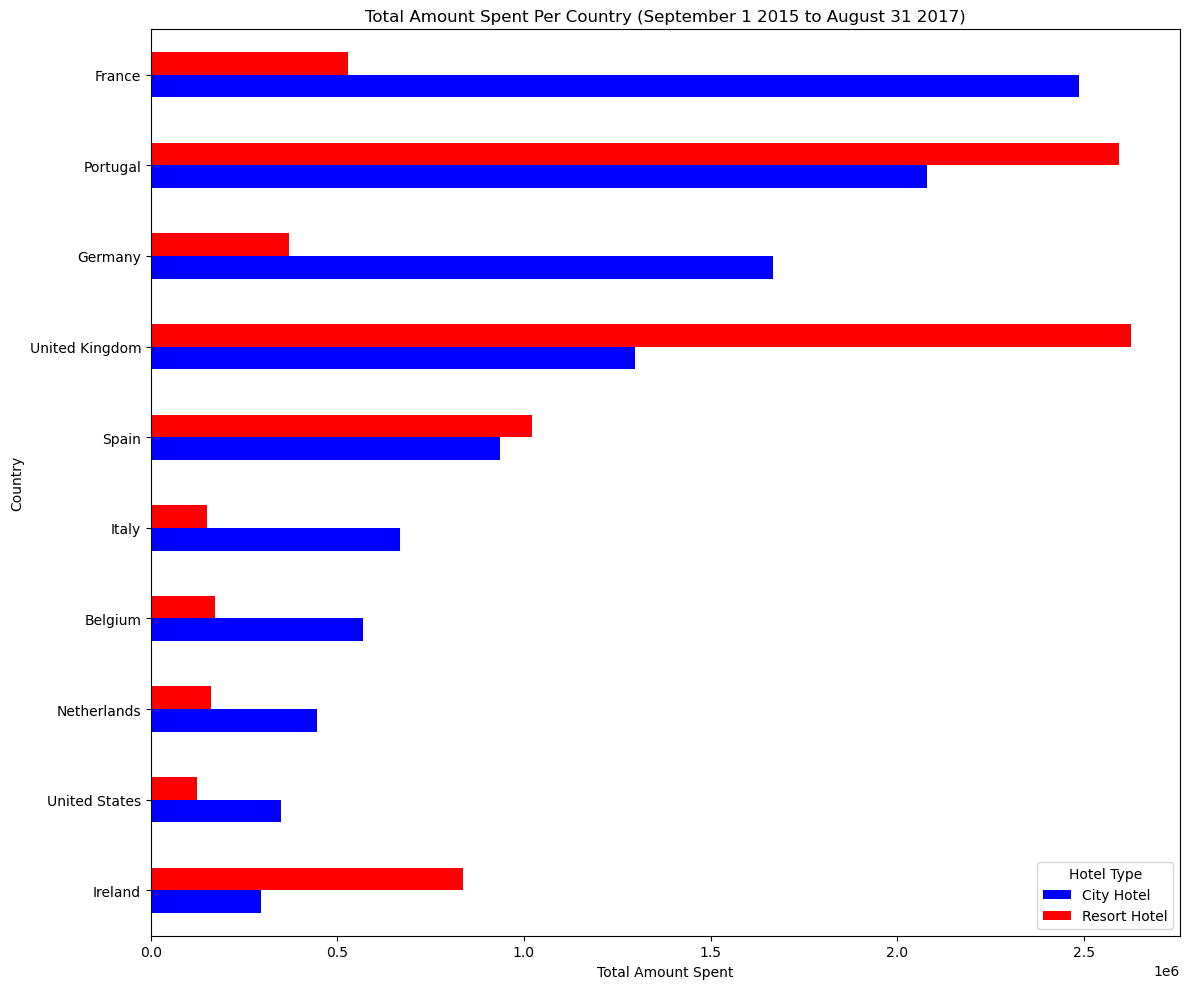

In [13]:

check_outs_df = data_df[
    (data_df['reservation_status'] == 'Check-Out') &
    (data_df['arrival_date'] >= start_date) &
    (data_df['arrival_date'] <= end_date)
].copy()


# Group by 'country' and 'hotel' and sum the 'amount_spent', then sort by the sum
grouped_data = check_outs_df.groupby(['Country Name', 'hotel'])['amount_spent'].sum().reset_index()

# Get the top 25 countries by amount spent
top_countries = grouped_data.groupby('Country Name')['amount_spent'].sum().nlargest(10).index

# Filter the grouped data for the top countries
top_grouped_data = grouped_data[grouped_data['Country Name'].isin(top_countries)]

# Pivot data to have hotels as columns and countries as rows
pivot_data = top_grouped_data.pivot(index='Country Name', columns='hotel', values='amount_spent')

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Horizontal bar plot, City Hotel in blue, Resort Hotel in red
pivot_data.sort_values(by='City Hotel', ascending=True).plot(kind='barh', color={'City Hotel': 'blue', 'Resort Hotel': 'red'}, ax=ax)

# Add titles and labels
plt.title('Total Amount Spent Per Country (September 1 2015 to August 31 2017)')
plt.xlabel('Total Amount Spent')
plt.ylabel('Country')
plt.legend(title='Hotel Type')
plt.tight_layout()

# Show the plot
plt.show()

The plot illustrates the total amount spent per country at City Hotel and Resort Hotel from September 1, 2015, to August 31, 2017. The countries are listed on the y-axis, while the total amount spent (in millions) is shown on the x-axis. The bars are color-coded, with blue representing City Hotel and red representing Resort Hotel.

### Overall Trends:

- **Preference for Resort Hotel**: Countries like Portugal, United Kingdom, and Spain show a higher total amount spent at Resort Hotel.
- **Preference for City Hotel**: France and Germany have higher or comparable spending at City Hotel.
- **Lower Total Spending**: Italy, Belgium, Netherlands, United States, and Ireland show relatively lower total spending compared to the top countries but with varying preferences between the two hotel types.

### Conclusion:

The plot highlights the spending patterns of different countries at City Hotel and Resort Hotel, indicating varying preferences and spending capacities. Portugal and the United Kingdom stand out with the highest total spending, particularly favoring Resort Hotel.

---
### 9. Amount Spent vs Room Nights

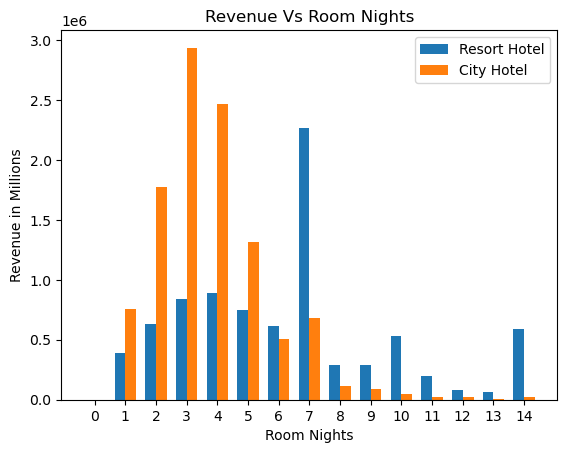

In [14]:
# Filter for rows where the reservation status is 'Check-Out'
checked_out_df = data_df[data_df['reservation_status'] == "Check-Out"]

# Further filter for rows where room_nights is less than or equal to 14
checked_out_df = checked_out_df[checked_out_df['room_nights'] <= 14]

# Preparing the data for clustering by hotel type
resort_hotel = checked_out_df[checked_out_df['hotel'] == 'Resort Hotel']
city_hotel = checked_out_df[checked_out_df['hotel'] == 'City Hotel']

# Find the total amount_spent for each number of room_nights for each hotel
resort_hotel_grouped = resort_hotel.groupby('room_nights')['amount_spent'].sum().reset_index()
city_hotel_grouped = city_hotel.groupby('room_nights')['amount_spent'].sum().reset_index()

# For the bar chart, we ensure that both dataframes have the same room_nights values
room_nights_values = sorted(set(resort_hotel_grouped['room_nights']) | set(city_hotel_grouped['room_nights']))
resort_hotel_grouped = resort_hotel_grouped.set_index('room_nights').reindex(room_nights_values).reset_index()
city_hotel_grouped = city_hotel_grouped.set_index('room_nights').reindex(room_nights_values).reset_index()

# Filling NaN values with 0 as some nights may not have entries in both hotel types
resort_hotel_grouped = resort_hotel_grouped.fillna(0)
city_hotel_grouped = city_hotel_grouped.fillna(0)

# Plotting the bar chart
bar_width = 0.35
index = np.arange(len(room_nights_values))

fig, ax = plt.subplots()
bar1 = ax.bar(index, resort_hotel_grouped['amount_spent'], bar_width, label='Resort Hotel')
bar2 = ax.bar(index + bar_width, city_hotel_grouped['amount_spent'], bar_width, label='City Hotel')

# Adding labels and title
ax.set_xlabel('Room Nights')
ax.set_ylabel('Revenue in Millions')
ax.set_title('Revenue Vs Room Nights')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(room_nights_values)
ax.legend()

# Showing the plot
plt.show()

The plot shows the relationship between the total amount spent (in millions) by guests and the number of room nights at City Hotel and Resort Hotel. The x-axis represents the number of room nights, and the y-axis represents the total amount spent in millions. The bars are color-coded, with blue representing Resort Hotel and orange representing City Hotel.

### Key Observations:

1. **Room Nights Distribution**:
   - Most of the revenue is concentrated around 1 to 7 room nights.
   - There's a noticeable drop in revenue beyond 7 room nights.

2. **revenue Patterns**:
   - **City Hotel**:
     - Peaks at 3 and 4 room nights, with the highest revenue at 4 room nights.
     - Significant revenue also observed for 1, 2, and 5 room nights.
     - Much lower revenue for room nights beyond 7.
   - **Resort Hotel**:
     - Peaks at 1, 3, 6, and 7 room nights, with the highest revenue at 7 room nights.
     - Noticeable revenue for 2, 4, and 5 room nights as well.
     - Exhibits a more spread-out revenue pattern across different room nights compared to City Hotel.

3. **Comparison Between Hotels**:
   - For shorter stays (1 to 3 room nights), City Hotel generally shows higher revenue.
   - For longer stays (6 to 7 room nights), Resort Hotel shows higher revenue.
   - Both hotels show minimal revenue beyond 10 room nights.

### Overall Trends:

- **Short Stays (1-3 Nights)**: Higher revenue is more prevalent at City Hotel.
- **Moderate Stays (4-5 Nights)**: Both hotels show substantial revenue, but City Hotel peaks at 4 room nights.
- **Longer Stays (6-7 Nights)**: Resort Hotel sees higher revenue, especially at 7 room nights.
- **Extended Stays (Beyond 10 Nights)**: revenue is minimal for both hotels.

### Conclusion:

The plot indicates that City Hotel attracts more revenue for shorter stays (up to 4 nights), while Resort Hotel attracts more revenue for longer stays (6 to 7 nights). Both hotels see a decline in revenue for room nights beyond 7, with minimal revenue for stays longer than 10 nights.

---

### 10. Customer Segments by hotel type

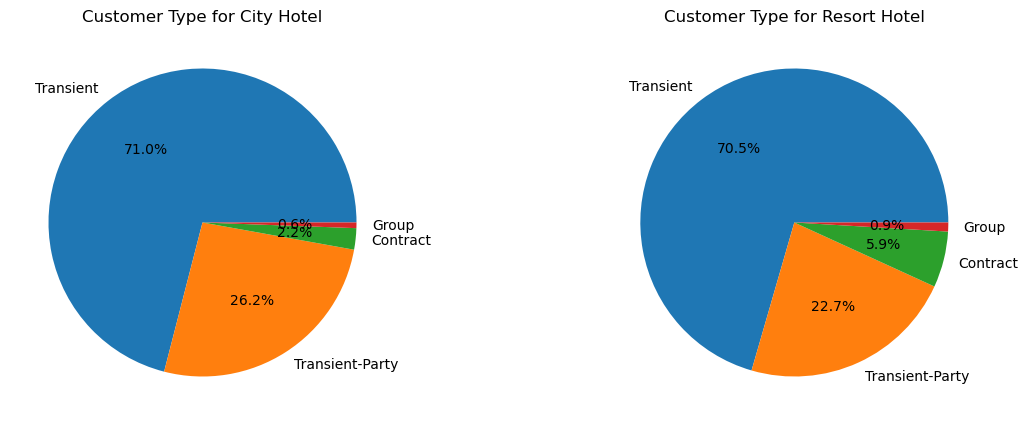

In [15]:
# First, we need to get the counts for each customer type for each hotel
city_hotel_counts = data_df[data_df['hotel'] == 'City Hotel']['customer_type'].value_counts()
resort_hotel_counts = data_df[data_df['hotel'] == 'Resort Hotel']['customer_type'].value_counts()

# Now we can plot the pie charts
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].pie(city_hotel_counts, labels=city_hotel_counts.index, autopct='%1.1f%%')
ax[0].set_title('Customer Type for City Hotel')

ax[1].pie(resort_hotel_counts, labels=resort_hotel_counts.index, autopct='%1.1f%%')
ax[1].set_title('Customer Type for Resort Hotel')

plt.show()

The pie charts illustrate the distribution of customer segments for city hotels and resort hotels. Here are the key points:

- **Transient** customers are the dominant segment for both city and resort hotels, making up about 70-71% of the total.
- **Transient-Party** customers are the second largest segment for both hotel types, though they constitute a slightly higher percentage in city hotels (26.2%) compared to resort hotels (22.7%).
- **Group** bookings are minimal for both hotel types, slightly higher in resort hotels (0.9% vs. 0.6%).
- **Contract** customers make up a larger proportion in resort hotels (5.9%) compared to city hotels (2.2%).

---

### 11. Bookings by month and day of week

C:\Users\DELL\AppData\Local\Temp\ipykernel_14688\536908415.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[:, 'arrival_date_month_num'] = data_df['arrival_date_month'].map(month_map)


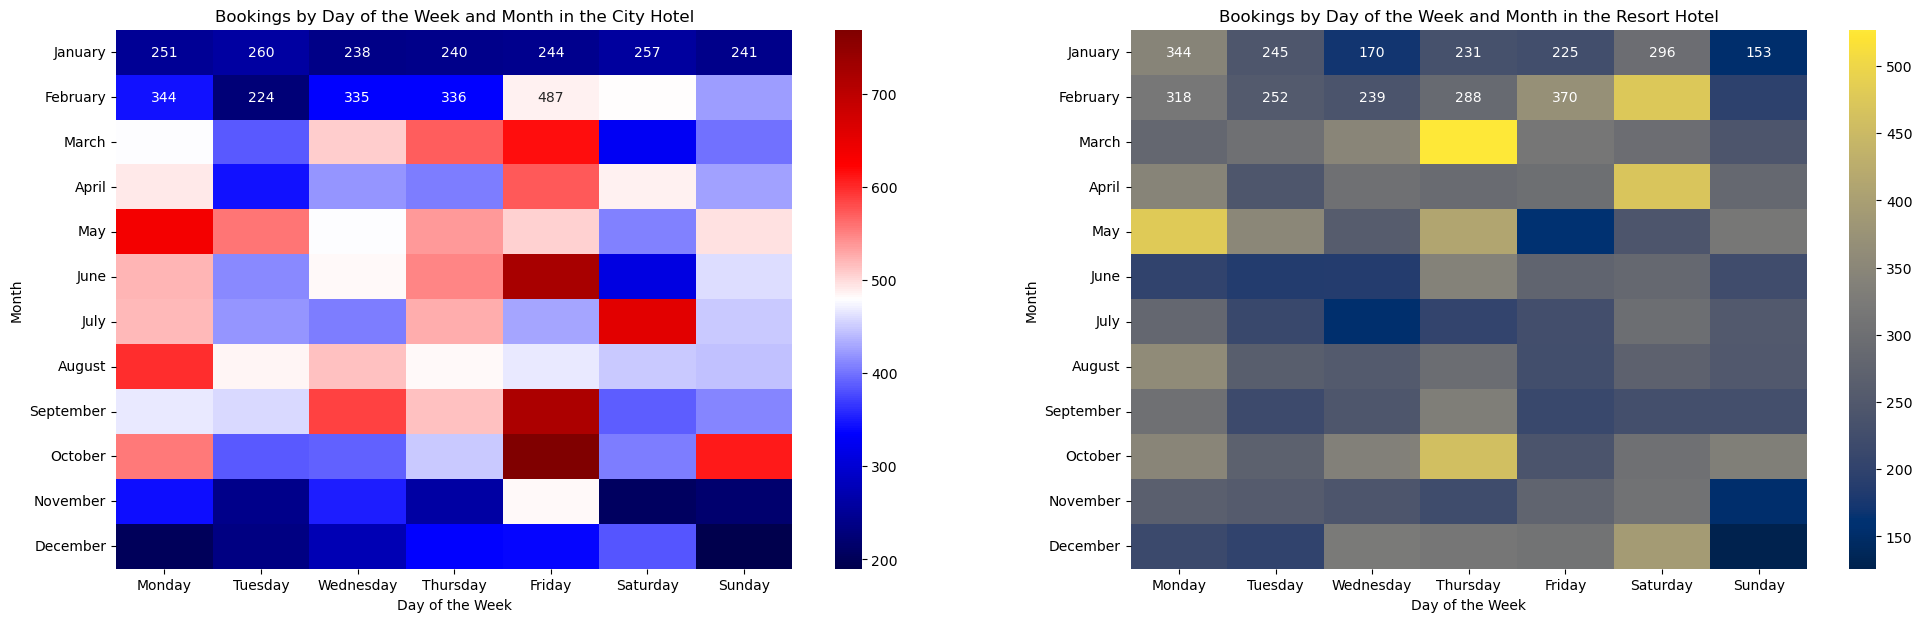

In [16]:
# Map the month names to numbers to ensure chronological order
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Apply the month map to create a numerical month column
data_df.loc[:, 'arrival_date_month_num'] = data_df['arrival_date_month'].map(month_map)


# Get Rows associated with City Hotel
city_data = data_df.loc[data_df['hotel'] == 'City Hotel'].copy()

# Create a pivot table with counts of bookings for City Hotel
pivot_table_city = city_data.pivot_table(index='arrival_date_month_num', columns='day_of_week', aggfunc='size', 
                                         fill_value=0, observed=False)

# Order the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table_city = pivot_table_city[days_order]  # Reorder the columns

# Map the month numbers back to names for better readability in the heatmap
pivot_table_city.index = pivot_table_city.index.map({v: k for k, v in month_map.items()})

# Get Rows associated with Resort Hotel
resort_data = data_df.loc[data_df['hotel'] == 'Resort Hotel'].copy()

# Create a pivot table with counts of bookings for Resort Hotel
pivot_table_resort = resort_data.pivot_table(index='arrival_date_month_num', columns='day_of_week', aggfunc='size', 
                                             fill_value=0, observed=False)
pivot_table_resort = pivot_table_resort[days_order]  # Reorder the columns

# Map the month numbers back to names for better readability in the heatmap
pivot_table_resort.index = pivot_table_resort.index.map({v: k for k, v in month_map.items()})

# Create the heatmaps
fig, ax = plt.subplots(1, 2, figsize=(24, 7))

sns.heatmap(pivot_table_city, annot=True, fmt="d", cmap="seismic", ax=ax[0])
ax[0].set_title('Bookings by Day of the Week and Month in the City Hotel')
ax[0].set_xlabel('Day of the Week')
ax[0].set_ylabel('Month')

sns.heatmap(pivot_table_resort, annot=True, fmt="d", cmap="cividis", ax=ax[1])
ax[1].set_title('Bookings by Day of the Week and Month in the Resort Hotel')
ax[1].set_xlabel('Day of the Week')
ax[1].set_ylabel('Month')

plt.show()


This is a side-by-side comparison of two heat maps showing booking data for a city hotel and a resort hotel. Here's a summary of the key patterns:

- **City Hotel Peak**: High booking numbers in **May** and **October**, particularly on **Mondays**.
- **City Hotel Low**: Fewest bookings on **Saturdays** across various months.
- **Resort Hotel Peak**: Highest bookings in **August**, especially on **Sundays**.
- **Resort Hotel Low**: Lower bookings in **November** and **December**.

These patterns suggest that the city hotel is busiest during the spring and fall, while the resort hotel sees more activity during the summer. Saturdays are less popular for city hotel stays, and the end of the year is quieter for the resort hotel. This information could be useful for resource planning and marketing strategies.

---
### 12. Relationship between lead time and the likelihood of cancellation

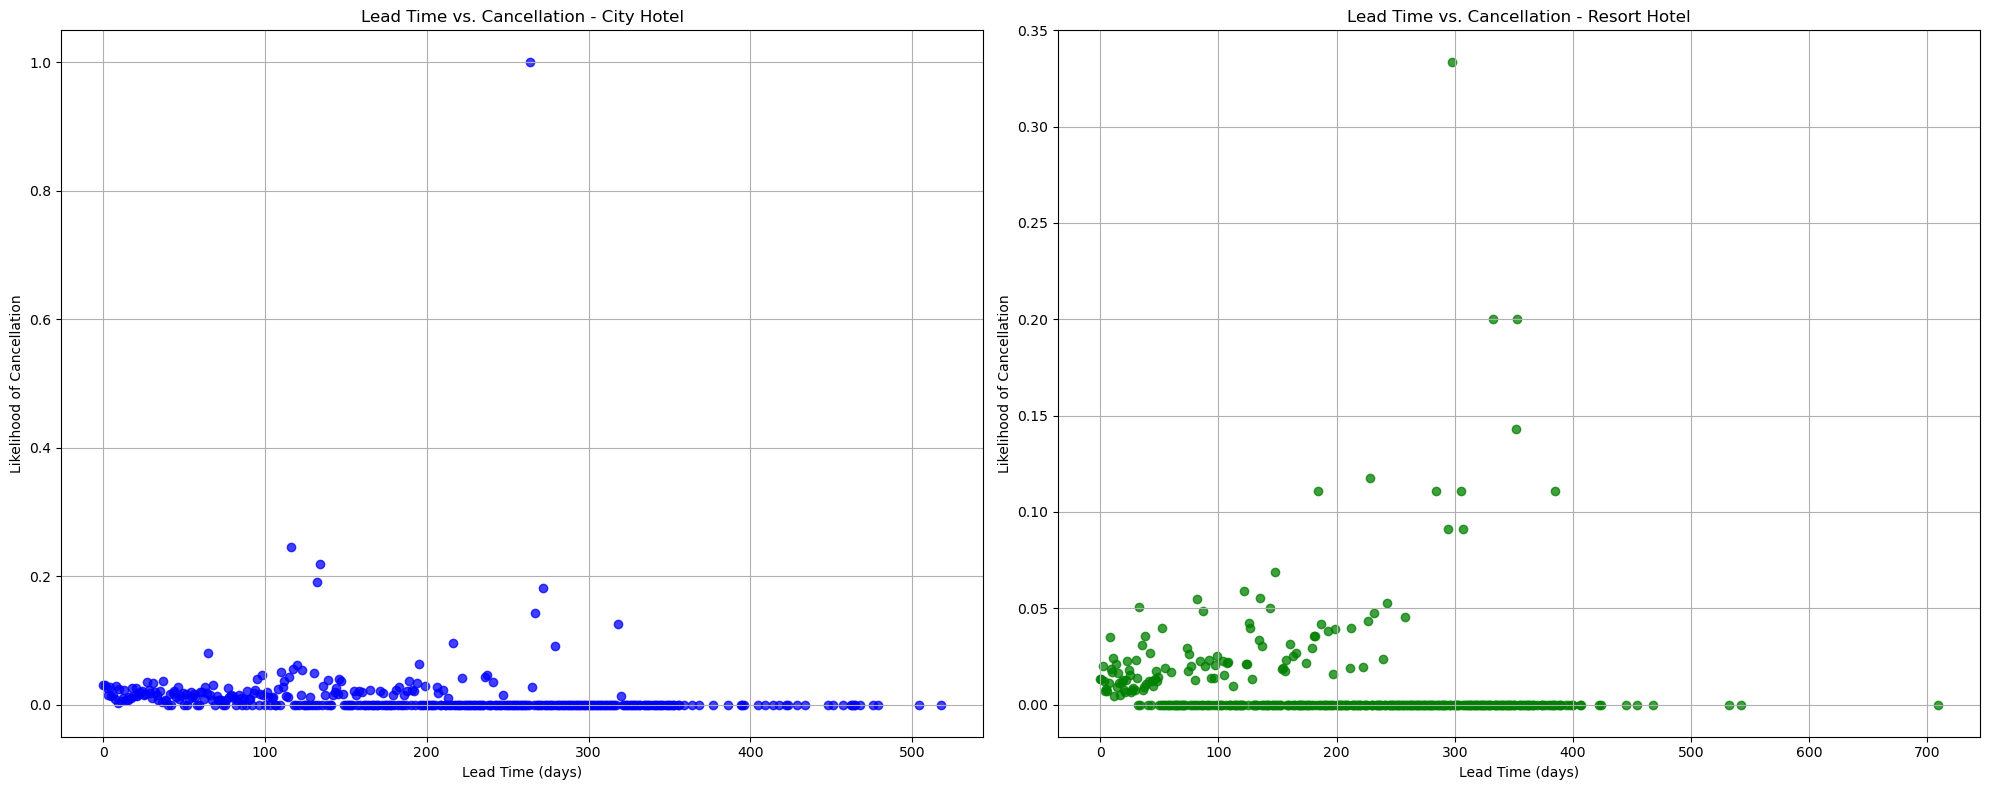

In [17]:

# Filter data to include only relevant columns for City Hotel and Resort Hotel
df_city = data_df[(data_df['hotel'] == 'City Hotel')][['lead_time', 'is_canceled']]
df_resort = data_df[(data_df['hotel'] == 'Resort Hotel')][['lead_time', 'is_canceled']]

# Group by lead time and calculate cancellation likelihood (mean cancellation rate) for City Hotel
grouped_city = df_city.groupby('lead_time')['is_canceled'].mean().reset_index()

# Group by lead time and calculate cancellation likelihood (mean cancellation rate) for Resort Hotel
grouped_resort = df_resort.groupby('lead_time')['is_canceled'].mean().reset_index()

# Create subplots for side by side display
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plotting the scatter plot for City Hotel
ax[0].scatter(grouped_city['lead_time'], grouped_city['is_canceled'], color='blue', alpha=0.75)
ax[0].set_title('Lead Time vs. Cancellation - City Hotel')
ax[0].set_xlabel('Lead Time (days)')
ax[0].set_ylabel('Likelihood of Cancellation')
ax[0].grid(True)

# Plotting the scatter plot for Resort Hotel
ax[1].scatter(grouped_resort['lead_time'], grouped_resort['is_canceled'], color='green', alpha=0.75)
ax[1].set_title('Lead Time vs. Cancellation - Resort Hotel')
ax[1].set_xlabel('Lead Time (days)')
ax[1].set_ylabel('Likelihood of Cancellation')
ax[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


This plot shows the relationship between lead time (the number of days between booking and arrival) and the likelihood of cancellation for two different types of hotels: City Hotel and Resort Hotel. The x-axis represents the lead time in days, while the y-axis represents the likelihood of cancellation, calculated as the mean cancellation rate.

### Key Observations:

1. **City Hotel (Left Plot):**
   - Most bookings have a short lead time (0-100 days).
   - There's a noticeable spike in cancellation likelihood around the maximum lead time, indicating that very early bookings have a higher chance of being canceled.
   - For most other lead times, the likelihood of cancellation remains relatively low.

2. **Resort Hotel (Right Plot):**
   - Similar to the City Hotel, most bookings have a short lead time (0-100 days).
   - There is a more gradual increase in cancellation likelihood as the lead time increases, with noticeable spikes around 200-300 days.
   - Some long lead times (400-700 days) also show cancellations, though these instances are less frequent.

### Interpretation:

- **Short Lead Times:** For both hotels, bookings with shorter lead times (0-100 days) are the most common. The likelihood of cancellation is generally low in this range, suggesting that last-minute bookings are more likely to be honored.
- **Long Lead Times:** Both plots show that bookings with longer lead times have higher cancellation rates. This could be due to changes in plans over time, making it more likely for guests to cancel.
- **Hotel Type Differences:** The Resort Hotel shows a more consistent trend of increasing cancellation likelihood with lead time, while the City Hotel has a noticeable peak at the longest lead time.

Overall, the plots suggest that the likelihood of cancellation increases with lead time for both types of hotels, but the patterns and magnitudes differ between the City and Resort hotels.

In [28]:
hotel_bookings_path = "Resources/hotel_bookingsl.csv"
hotel_bookings = pd.read_csv(hotel_bookings_path)
hotel_bookings_original_path = "Resources/hotel_bookings_originall.csv"
hotel_bookings_original = pd.read_csv(hotel_bookings_original_path)
hotel_bookings.replace([np.inf, -np.inf], np.nan, inplace=True)
hotel_bookings_original.replace([np.inf, -np.inf], np.nan, inplace=True)

In [29]:
# Create a new column combining arrival_date_day_of_month, arrival_date_month, and arrival_date_year into a date
hotel_bookings['arrival_date'] = pd.to_datetime(hotel_bookings['arrival_date_day_of_month'].astype(str) + '-' +
                                                 hotel_bookings['arrival_date_month'] + '-' +
                                                 hotel_bookings['arrival_date_year'].astype(str),
                                                 format='%d-%B-%Y')

# Create a new DataFrame with the new 'arrival_date' column
corrected_date_hotel_bookings_df = hotel_bookings.copy()
corrected_date_hotel_bookings_df.sample(5)

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,month_num,arrival_date,day_of_week
26446,48700,City Hotel,0,82,2016,March,14,27,2,3,...,0,Transient,84.15,0,1,Check-Out,1/4/2016,3,2016-03-27,Sunday
56907,116310,City Hotel,0,10,2017,July,28,14,2,2,...,0,Transient,119.00,0,1,Check-Out,18-07-17,7,2017-07-14,Friday
31362,83722,City Hotel,0,4,2016,February,7,9,0,1,...,0,Transient,86.00,0,0,Check-Out,10/2/2016,2,2016-02-09,Tuesday
56160,115305,City Hotel,0,13,2017,July,27,3,1,0,...,0,Transient,120.00,0,1,Check-Out,4/7/2017,7,2017-07-03,Monday
39860,94226,City Hotel,0,3,2017,January,3,16,1,0,...,0,Transient,65.00,0,1,Check-Out,17-01-17,1,2017-01-16,Monday


In [30]:
#Seeing all the columns in the dataframe
column_headings = corrected_date_hotel_bookings_df.columns.tolist()
print(column_headings)

['index', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date', 'month_num', 'arrival_date', 'day_of_week']


In [31]:
#Adding number of nights column
corrected_date_hotel_bookings_df['total_nights'] = corrected_date_hotel_bookings_df['stays_in_weekend_nights'] + corrected_date_hotel_bookings_df['stays_in_week_nights']
bookings_with_total_nights_df = corrected_date_hotel_bookings_df[['index', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date', 'month_num', 'arrival_date', 'day_of_week', 'total_nights']]
bookings_with_total_nights_df.sample(10)

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,month_num,arrival_date,day_of_week,total_nights
43739,98986,City Hotel,0,29,2016,October,41,5,0,2,...,Transient,152.00,0,2,Check-Out,7/10/2016,10,2016-10-05,Wednesday,2
25265,45280,City Hotel,0,69,2015,October,44,25,2,1,...,Transient-Party,85.67,0,0,Check-Out,28-10-15,10,2015-10-25,Sunday,3
27012,54208,City Hotel,0,185,2016,July,28,8,2,2,...,Transient,70.03,0,2,Check-Out,12/7/2016,7,2016-07-08,Friday,4
39284,93550,City Hotel,0,292,2016,July,30,21,0,2,...,Transient-Party,115.00,0,0,Check-Out,23-07-16,7,2016-07-21,Thursday,2
51538,109211,City Hotel,0,111,2017,April,14,5,0,3,...,Transient,99.00,0,1,Check-Out,8/4/2017,4,2017-04-05,Wednesday,3
17277,32644,Resort Hotel,0,6,2017,January,5,30,1,1,...,Transient,35.11,0,1,Check-Out,1/2/2017,1,2017-01-30,Monday,2
56232,115407,City Hotel,0,405,2017,July,27,4,0,2,...,Transient-Party,114.40,0,0,Check-Out,6/7/2017,7,2017-07-04,Tuesday,2
52937,111061,City Hotel,0,65,2017,May,18,4,0,2,...,Transient,240.30,0,0,Check-Out,6/5/2017,5,2017-05-04,Thursday,2
41384,96081,City Hotel,0,8,2016,August,35,22,1,5,...,Transient,99.46,0,1,Check-Out,28-08-16,8,2016-08-22,Monday,6
24083,43102,City Hotel,0,61,2015,September,38,15,0,1,...,Transient,80.75,0,0,Check-Out,16-09-15,9,2015-09-15,Tuesday,1


In [32]:
#Adding Revenue column
bookings_with_total_nights_df['total_revenue'] = bookings_with_total_nights_df['adr'] * bookings_with_total_nights_df['total_nights']
df_with_revenue = bookings_with_total_nights_df[['index', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date', 'month_num', 'arrival_date', 'day_of_week', 'total_nights','total_revenue']]
df_with_revenue.sample(5)

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,month_num,arrival_date,day_of_week,total_nights,total_revenue
38567,92653,City Hotel,0,9,2016,July,28,8,0,2,...,167.10,1,1,Check-Out,10/7/2016,7,2016-07-08,Friday,2,334.2
50085,107365,City Hotel,0,14,2017,March,10,8,0,4,...,104.55,0,1,Check-Out,12/3/2017,3,2017-03-08,Wednesday,4,418.2
6160,19994,Resort Hotel,0,0,2016,January,3,11,1,0,...,51.00,0,0,Check-Out,12/1/2016,1,2016-01-11,Monday,1,51.0
57732,117404,City Hotel,0,44,2017,July,31,30,2,2,...,160.00,0,1,Check-Out,3/8/2017,7,2017-07-30,Sunday,4,640.0
56860,116224,City Hotel,0,3,2017,July,28,14,1,2,...,115.00,0,0,Check-Out,17-07-17,7,2017-07-14,Friday,3,345.0


In [33]:
total_revenue_made_for_both_hotels = df_with_revenue["total_revenue"].sum()
total_revenue_made_for_both_hotels

19647981.99

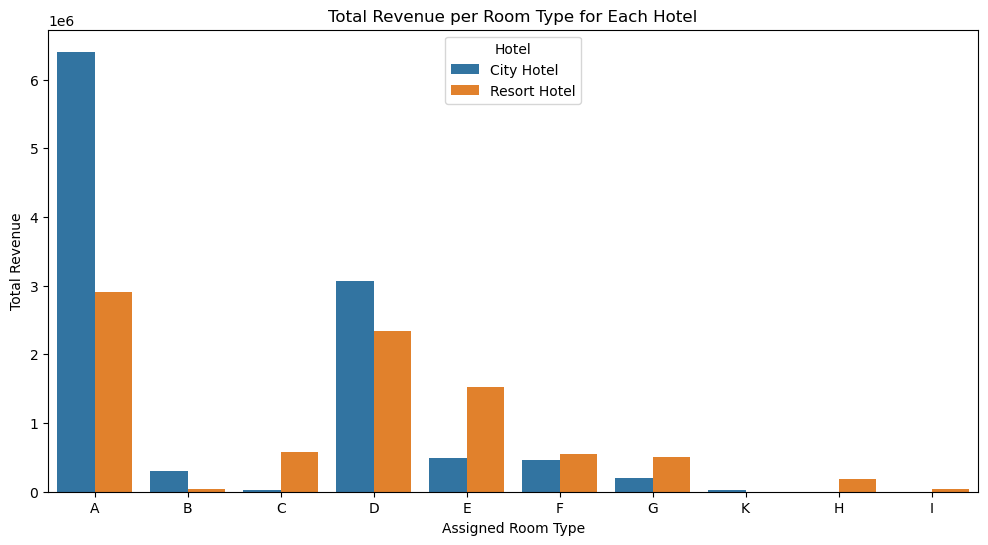

In [34]:
# Calculate the total revenue per room type for each hotel
hotel_room_revenue = df_with_revenue.groupby(['hotel', 'assigned_room_type']).agg({'total_revenue': 'sum'}).reset_index()

# Rename columns for clarity
hotel_room_revenue.columns = ['Hotel', 'Assigned Room Type', 'Total Revenue']

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the bar chart
sns.barplot(data=hotel_room_revenue, x='Assigned Room Type', y='Total Revenue', hue='Hotel')

# Set the title and labels
plt.title('Total Revenue per Room Type for Each Hotel')
plt.xlabel('Assigned Room Type')
plt.ylabel('Total Revenue')

# Display the bar chart
plt.show()

In [35]:
#creating a df with only city hotels
city_hotel_df = df_with_revenue[df_with_revenue['hotel'] == 'City Hotel']
city_hotel_df.sample(10)

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,month_num,arrival_date,day_of_week,total_nights,total_revenue
34151,87103,City Hotel,0,26,2016,April,16,13,0,1,...,182.00,0,2,Check-Out,14-04-16,4,2016-04-13,Wednesday,1,182.00
35160,88384,City Hotel,0,3,2016,May,19,2,1,2,...,110.21,0,0,Check-Out,5/5/2016,5,2016-05-02,Monday,3,330.63
44635,100119,City Hotel,0,1,2016,October,43,22,0,1,...,129.00,0,1,Check-Out,23-10-16,10,2016-10-22,Saturday,1,129.00
57999,117748,City Hotel,0,271,2017,August,31,2,2,5,...,107.10,0,1,Check-Out,9/8/2017,8,2017-08-02,Wednesday,7,749.70
52756,110821,City Hotel,0,140,2017,April,17,28,2,2,...,130.00,0,1,Check-Out,2/5/2017,4,2017-04-28,Friday,4,520.00
54581,113231,City Hotel,0,108,2017,June,22,2,0,2,...,126.00,0,1,Check-Out,4/6/2017,6,2017-06-02,Friday,2,252.00
33617,86485,City Hotel,0,60,2016,April,14,1,1,2,...,106.20,0,1,Check-Out,4/4/2016,4,2016-04-01,Friday,3,318.60
51794,109535,City Hotel,0,63,2017,April,14,7,2,4,...,135.00,0,2,Check-Out,13-04-17,4,2017-04-07,Friday,6,810.00
51196,108759,City Hotel,0,54,2017,March,13,28,0,4,...,48.50,0,0,Check-Out,1/4/2017,3,2017-03-28,Tuesday,4,194.00
27630,76711,City Hotel,0,2,2016,November,49,28,1,2,...,65.00,0,2,Check-Out,1/12/2016,11,2016-11-28,Monday,3,195.00


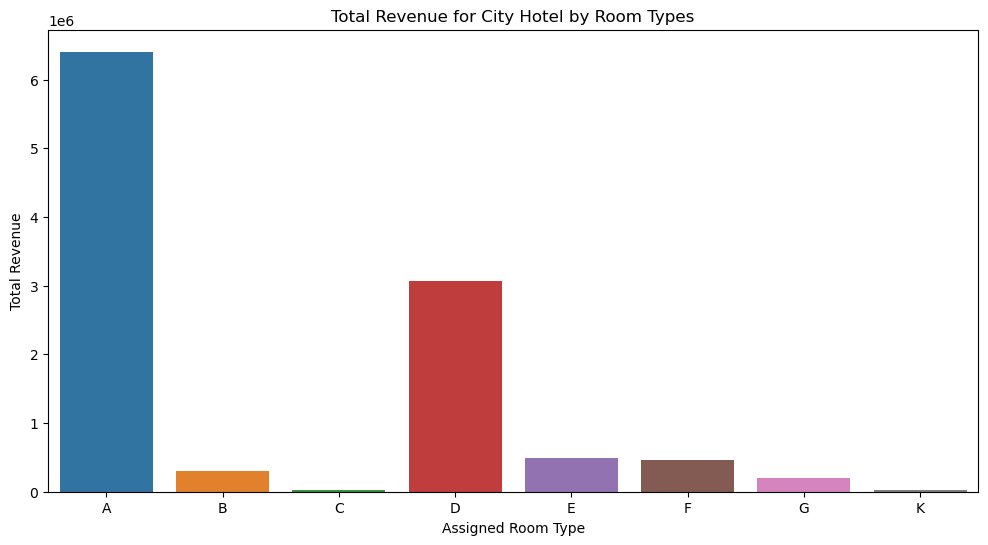

In [36]:
# Calculate the total revenue per room type for city hotel
city_hotel_room_revenue = city_hotel_df.groupby(['assigned_room_type']).agg({'total_revenue': 'sum'}).reset_index()

# Rename columns for clarity
city_hotel_room_revenue.columns = ['assigned Room Type', 'total Revenue']

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the bar chart
sns.barplot(data=city_hotel_room_revenue, x='assigned Room Type', y='total Revenue')

# Set the title and labels
plt.title('Total Revenue for City Hotel by Room Types')
plt.xlabel('Assigned Room Type')
plt.ylabel('Total Revenue')

# Display the bar chart
plt.show()

In [37]:
Resort_hotel_df = df_with_revenue[df_with_revenue['hotel'] == 'Resort Hotel']
Resort_hotel_df.sample(10)

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,month_num,arrival_date,day_of_week,total_nights,total_revenue
5149,18779,Resort Hotel,0,4,2015,November,48,28,0,1,...,34.19,0,0,Check-Out,29-11-15,11,2015-11-28,Saturday,1,34.19
22790,39298,Resort Hotel,0,191,2017,August,32,6,3,5,...,196.00,1,0,Check-Out,14-08-17,8,2017-08-06,Sunday,8,1568.00
7153,21063,Resort Hotel,0,1,2016,February,8,16,0,1,...,25.00,1,0,Check-Out,17-02-16,2,2016-02-16,Tuesday,1,25.00
21039,37048,Resort Hotel,0,1,2017,June,22,1,1,3,...,105.00,0,1,Check-Out,5/6/2017,6,2017-06-01,Thursday,4,420.00
5147,18777,Resort Hotel,0,15,2015,November,48,27,0,2,...,60.00,0,1,Check-Out,29-11-15,11,2015-11-27,Friday,2,120.00
13874,28783,Resort Hotel,0,0,2016,October,42,10,1,0,...,56.00,0,1,Check-Out,11/10/2016,10,2016-10-10,Monday,1,56.00
3504,16835,Resort Hotel,0,180,2015,September,36,1,4,10,...,131.40,0,1,Check-Out,15-09-15,9,2015-09-01,Tuesday,14,1839.60
12054,26638,Resort Hotel,0,180,2016,July,32,31,2,5,...,156.60,0,3,Check-Out,7/8/2016,7,2016-07-31,Sunday,7,1096.20
14971,30114,Resort Hotel,0,4,2016,November,47,14,1,0,...,43.00,0,2,Check-Out,15-11-16,11,2016-11-14,Monday,1,43.00
23118,39675,Resort Hotel,0,177,2017,August,33,19,2,4,...,239.00,0,1,Check-Out,25-08-17,8,2017-08-19,Saturday,6,1434.00


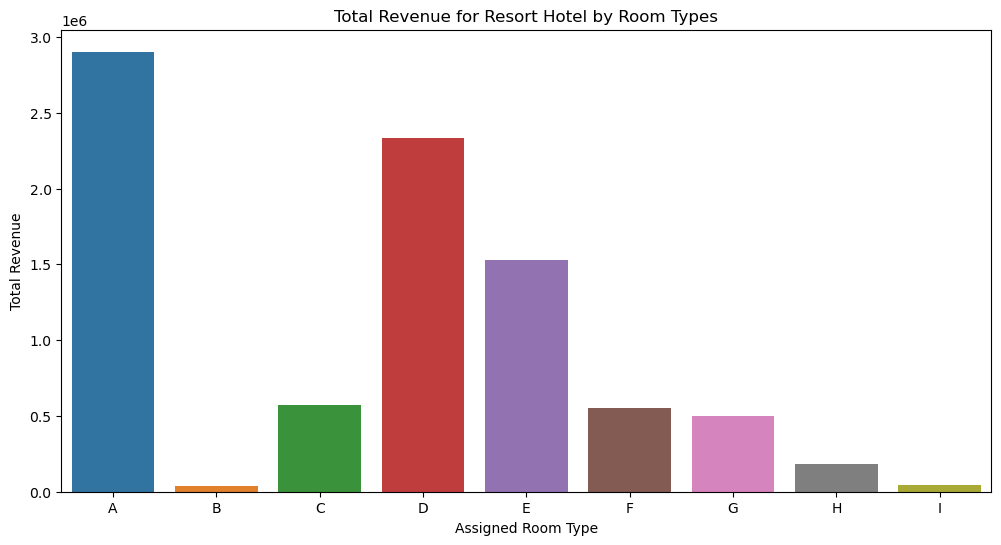

In [38]:
# Calculate the total revenue per room type for resort hotel
Resort_hotel_room_revenue = Resort_hotel_df.groupby(['assigned_room_type']).agg({'total_revenue': 'sum'}).reset_index()

# Rename columns for clarity
Resort_hotel_room_revenue.columns = ['assigned Room Type', 'total Revenue']

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the bar chart
sns.barplot(data=Resort_hotel_room_revenue, x='assigned Room Type', y='total Revenue')

# Set the title and labels
plt.title('Total Revenue for Resort Hotel by Room Types')
plt.xlabel('Assigned Room Type')
plt.ylabel('Total Revenue')

# Display the bar chart
plt.show()

In [39]:
# finding the percentage of booking cancelled
# Filter out canceled bookings
canceled_bookings = hotel_bookings_original[hotel_bookings_original['is_canceled'] == 1]

# Calculate the total number of canceled bookings
total_canceled = len(canceled_bookings)

# Calculate the number of canceled bookings for each deposit type
canceled_deposit_counts = canceled_bookings['deposit_type'].value_counts()

# Calculate the percentage of "Refundable" and "No Deposit" canceled bookings
refundable_percentage = (canceled_deposit_counts.get('Refundable', 0) / total_canceled) * 100
no_deposit_percentage = (canceled_deposit_counts.get('No Deposit', 0) / total_canceled) * 100
non_refund_percentage = (canceled_deposit_counts.get('Non Refund', 0) / total_canceled) * 100

# Print the results
print(f"Total Canceled Bookings: {total_canceled}")
print(f"Refundable Canceled Bookings: {refundable_percentage:.2f}%")
print(f"No Deposit Canceled Bookings: {no_deposit_percentage:.2f}%")
print(f"Non Refund Canceled Bookings: {non_refund_percentage:.2f}%")

Total Canceled Bookings: 44224
Refundable Canceled Bookings: 0.08%
No Deposit Canceled Bookings: 67.14%
Non Refund Canceled Bookings: 32.77%


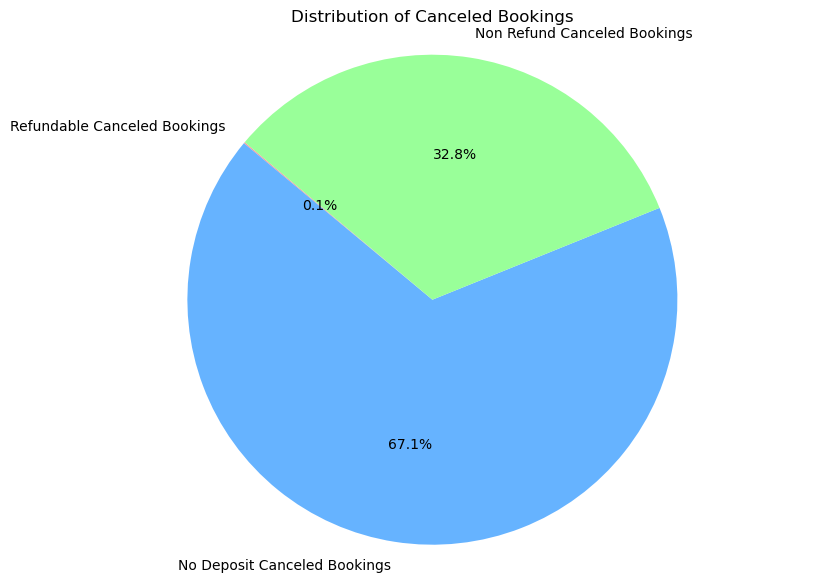

In [40]:


# Given data
total_canceled_bookings = 44224
refundable_percentage = 0.08
no_deposit_percentage = 67.14
non_refund_percentage = 32.77

# Calculate the number of bookings for each category
refundable_canceled_bookings = total_canceled_bookings * (refundable_percentage / 100)
no_deposit_canceled_bookings = total_canceled_bookings * (no_deposit_percentage / 100)
non_refund_canceled_bookings = total_canceled_bookings * (non_refund_percentage / 100)

# Data for the pie chart
labels = ['Refundable Canceled Bookings', 'No Deposit Canceled Bookings', 'Non Refund Canceled Bookings']
sizes = [refundable_canceled_bookings, no_deposit_canceled_bookings, non_refund_canceled_bookings]

# Create a pie chart
plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribution of Canceled Bookings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()

In [41]:
Resort_hotel_df.to_csv('Resort_hotel_df_data.csv')
city_hotel_df.to_csv('city_hotel_df_data.csv')

City Hotel Room Type Year by Year Growth

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


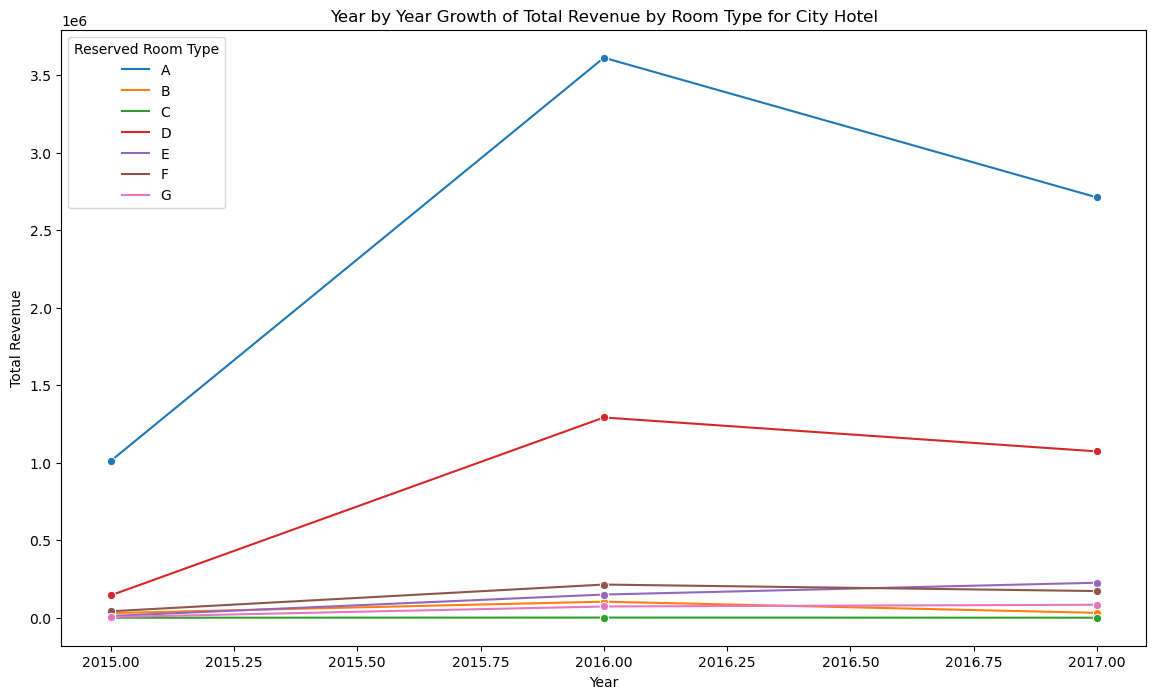

In [42]:
# Group by arrival_date_year and reserved_room_type and calculate the total revenue
grouped_data = city_hotel_df.groupby(['arrival_date_year', 'reserved_room_type']).agg({'total_revenue': 'sum'}).reset_index()

# Rename columns for clarity
grouped_data.columns = ['Year', 'Reserved Room Type', 'Total Revenue']

# Set the size of the plot
plt.figure(figsize=(14, 8))

# Create the line chart
sns.lineplot(data=grouped_data, x='Year', y='Total Revenue', hue='Reserved Room Type', marker='o')

# Set the title and labels
plt.title('Year by Year Growth of Total Revenue by Room Type for City Hotel')
plt.xlabel('Year')
plt.ylabel('Total Revenue')

# Display the line chart
plt.show()

Resort Hotel Room Type Year by Year Growth

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


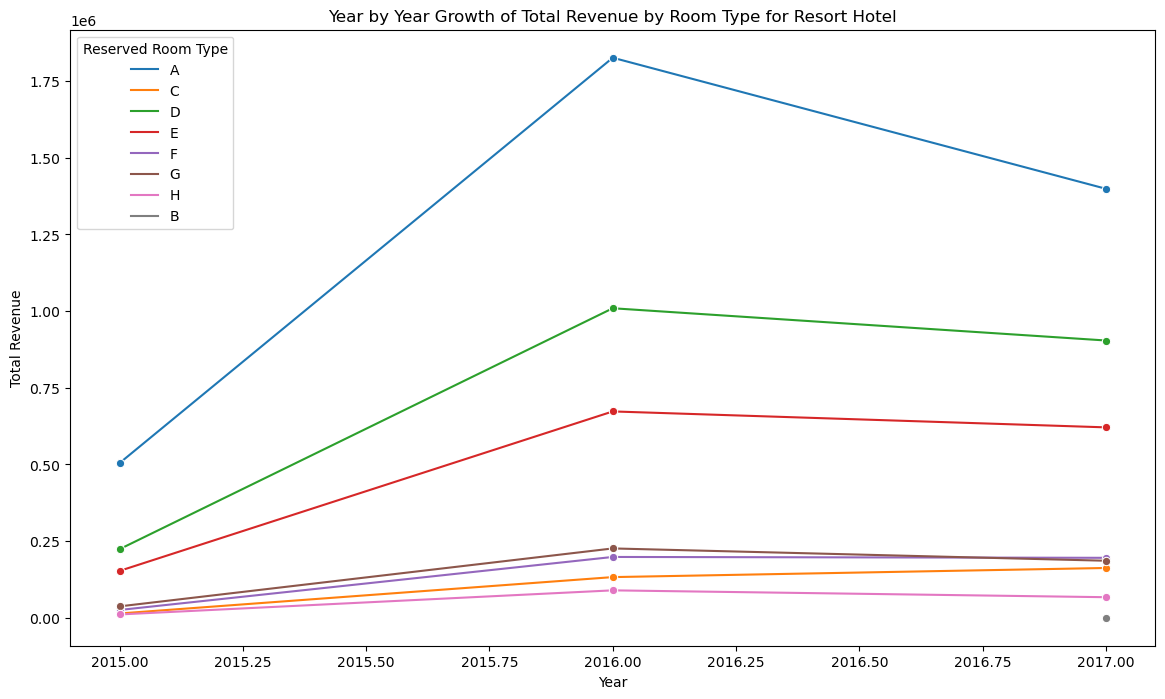

In [43]:
# Group by arrival_date_year and reserved_room_type and calculate the total revenue
grouped_data = Resort_hotel_df.groupby(['arrival_date_year', 'reserved_room_type']).agg({'total_revenue': 'sum'}).reset_index()

# Rename columns for clarity
grouped_data.columns = ['Year', 'Reserved Room Type', 'Total Revenue']

# Set the size of the plot
plt.figure(figsize=(14, 8))

# Create the line chart
sns.lineplot(data=grouped_data, x='Year', y='Total Revenue', hue='Reserved Room Type', marker='o')

# Set the title and labels
plt.title('Year by Year Growth of Total Revenue by Room Type for Resort Hotel')
plt.xlabel('Year')
plt.ylabel('Total Revenue')

# Display the line chart
plt.show()

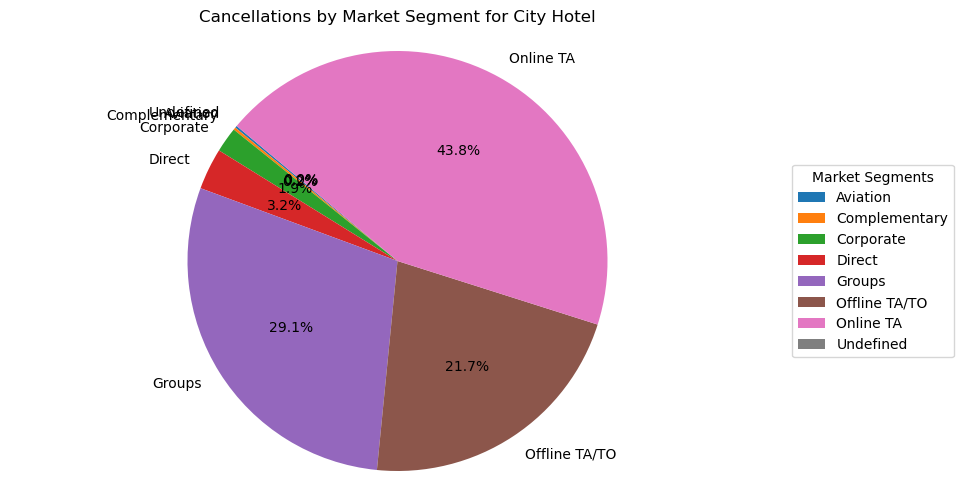

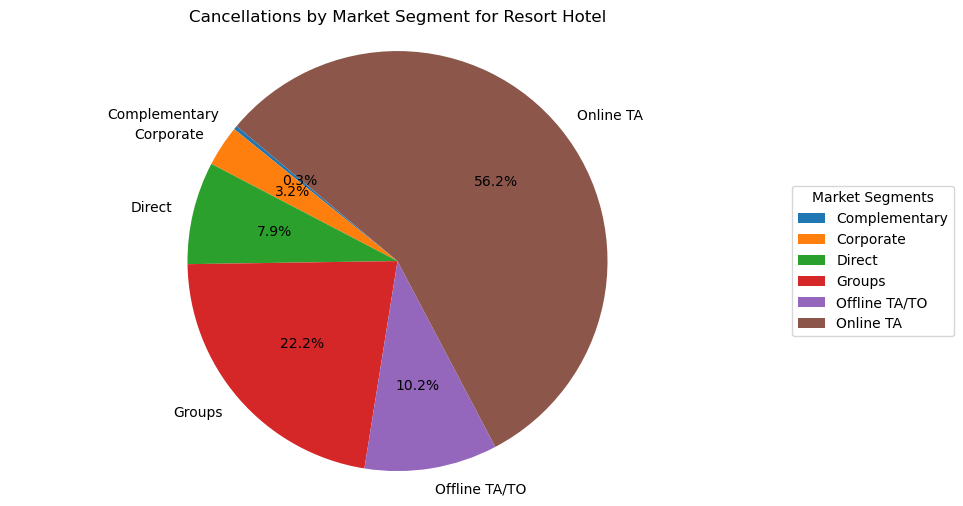

In [44]:
# Group by market_segment and hotel and calculate the number of cancellations
cancellations_data_city_and_resort = hotel_bookings_original[hotel_bookings_original['is_canceled'] == 1].groupby(['market_segment', 'hotel']).size().reset_index(name='cancellations')

# Create a pie chart for each hotel
hotels = cancellations_data_city_and_resort['hotel'].unique()

for hotel in hotels:
    hotel_cancellations = cancellations_data_city_and_resort[cancellations_data_city_and_resort['hotel'] == hotel]
    
    plt.figure(figsize=(10, 6))
    plt.pie(hotel_cancellations['cancellations'], labels=hotel_cancellations['market_segment'], autopct='%1.1f%%', startangle=140)
    plt.legend(hotel_cancellations['market_segment'], title="Market Segments", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title(f'Cancellations by Market Segment for {hotel}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


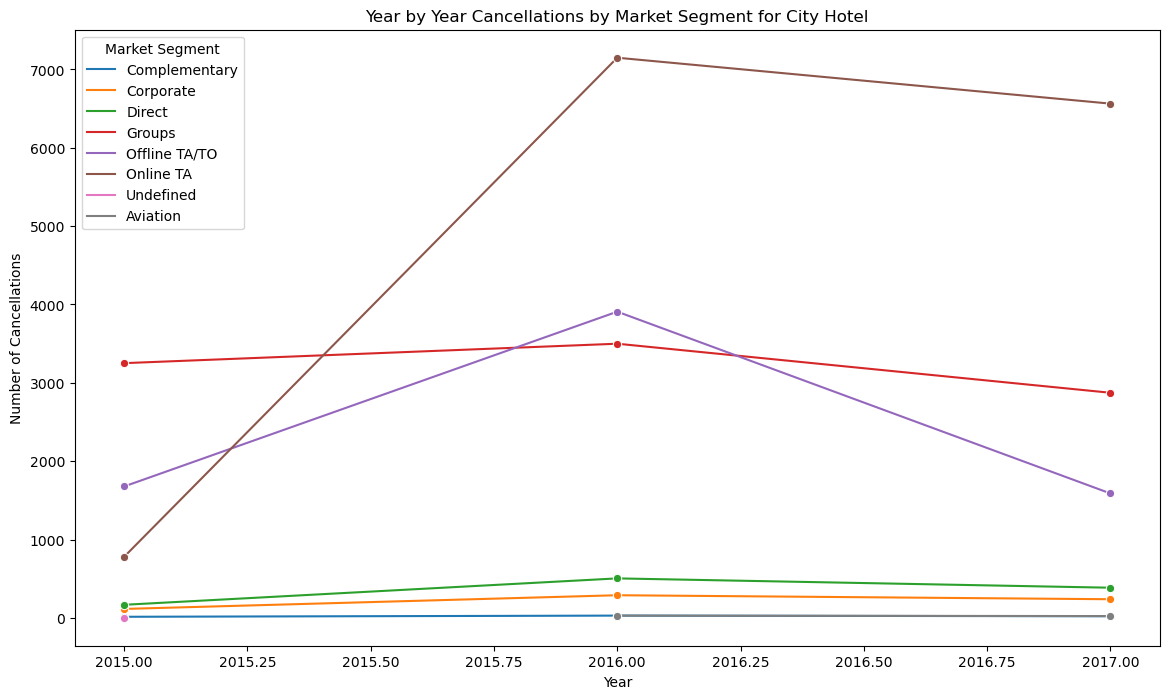

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


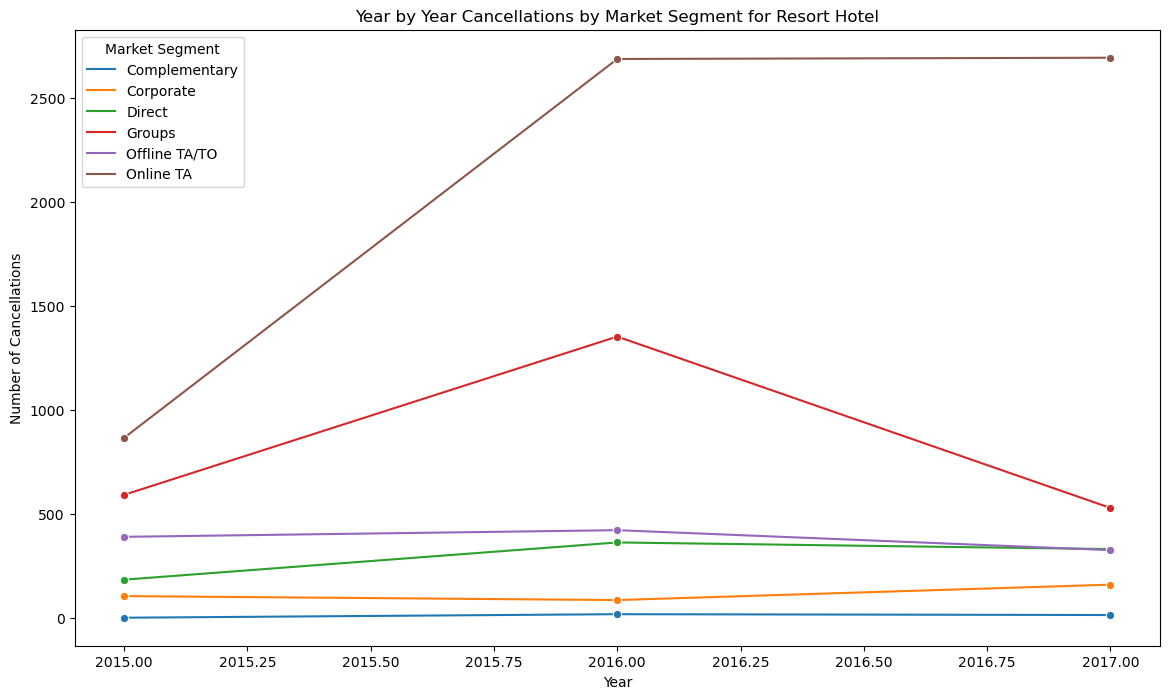

In [45]:
# Filter data for cancellations only
cancellations_data = hotel_bookings_original[hotel_bookings_original['is_canceled'] == 1]

# Group by arrival_date_year, market_segment, and hotel and calculate the number of cancellations
cancellations_grouped = cancellations_data.groupby(['arrival_date_year', 'market_segment', 'hotel']).size().reset_index(name='cancellations')

# Plot the data
hotels = cancellations_grouped['hotel'].unique()

for hotel in hotels:
    hotel_cancellations = cancellations_grouped[cancellations_grouped['hotel'] == hotel]
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=hotel_cancellations, x='arrival_date_year', y='cancellations', hue='market_segment', marker='o')
    
    plt.title(f'Year by Year Cancellations by Market Segment for {hotel}')
    plt.xlabel('Year')
    plt.ylabel('Number of Cancellations')
    plt.legend(title='Market Segment')
    plt.show()

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


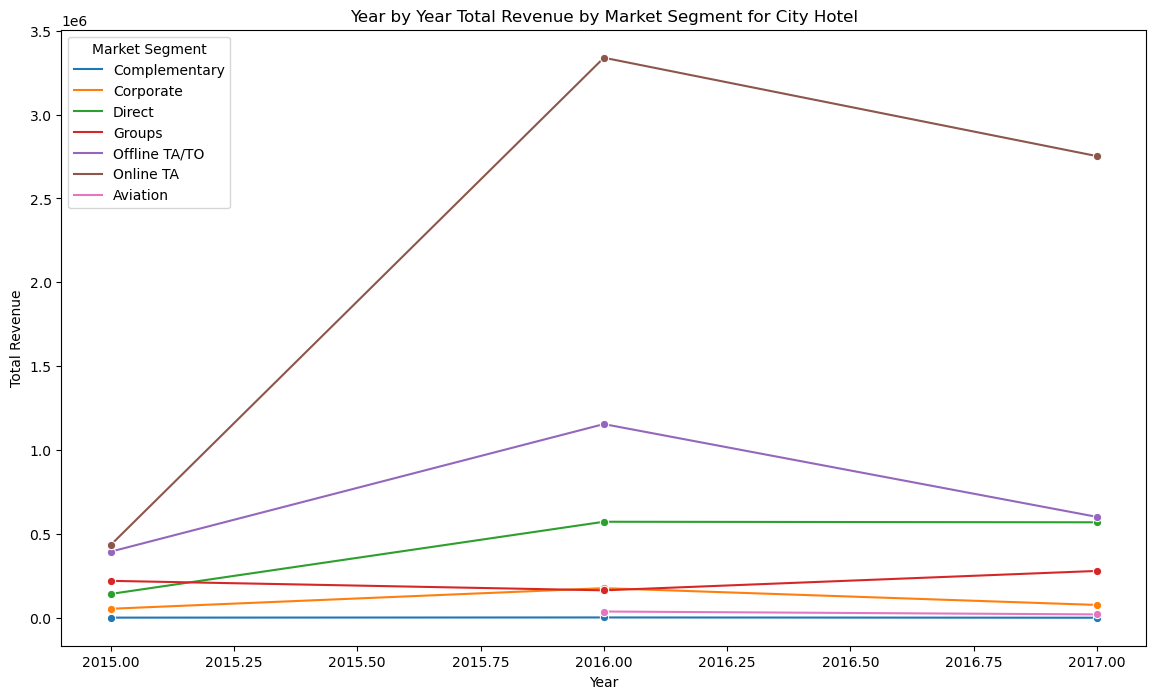

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


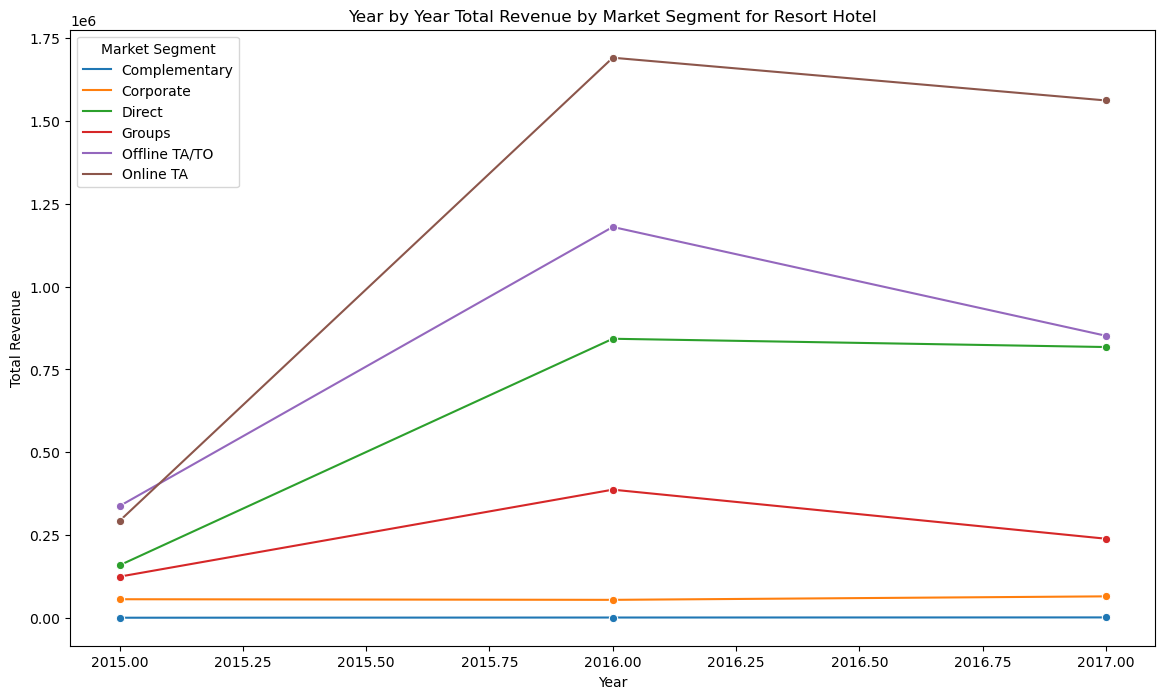

In [46]:
# Group by arrival_date_year, market_segment, and hotel and calculate the total revenue
revenue_grouped_market_segment= df_with_revenue.groupby(['arrival_date_year', 'market_segment', 'hotel']).agg({'total_revenue': 'sum'}).reset_index()

# Plot the data
hotels = revenue_grouped_market_segment['hotel'].unique()

for hotel in hotels:
    hotel_revenue = revenue_grouped_market_segment[revenue_grouped_market_segment['hotel'] == hotel]
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=hotel_revenue, x='arrival_date_year', y='total_revenue', hue='market_segment', marker='o')
    
    plt.title(f'Year by Year Total Revenue by Market Segment for {hotel}')
    plt.xlabel('Year')
    plt.ylabel('Total Revenue')
    plt.legend(title='Market Segment')
    plt.show()

This plot shows the relationship between lead time (the number of days between booking and arrival) and the likelihood of cancellation for two different types of hotels: City Hotel and Resort Hotel. The x-axis represents the lead time in days, while the y-axis represents the likelihood of cancellation, calculated as the mean cancellation rate.

### Key Observations:

1. **City Hotel (Left Plot):**
   - Most bookings have a short lead time (0-100 days).
   - There's a noticeable spike in cancellation likelihood around the maximum lead time, indicating that very early bookings have a higher chance of being canceled.
   - For most other lead times, the likelihood of cancellation remains relatively low.

2. **Resort Hotel (Right Plot):**
   - Similar to the City Hotel, most bookings have a short lead time (0-100 days).
   - There is a more gradual increase in cancellation likelihood as the lead time increases, with noticeable spikes around 200-300 days.
   - Some long lead times (400-700 days) also show cancellations, though these instances are less frequent.

### Interpretation:

- **Short Lead Times:** For both hotels, bookings with shorter lead times (0-100 days) are the most common. The likelihood of cancellation is generally low in this range, suggesting that last-minute bookings are more likely to be honored.
- **Long Lead Times:** Both plots show that bookings with longer lead times have higher cancellation rates. This could be due to changes in plans over time, making it more likely for guests to cancel.
- **Hotel Type Differences:** The Resort Hotel shows a more consistent trend of increasing cancellation likelihood with lead time, while the City Hotel has a noticeable peak at the longest lead time.

Overall, the plots suggest that the likelihood of cancellation increases with lead time for both types of hotels, but the patterns and magnitudes differ between the City and Resort hotels.

In [ ]:
hotel_csv = pd.read_csv("./Resources/hotel_bookings_agent.csv")
agent_columns = ['distribution_channel', 'previous_cancellations', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'reservation_status']
agent_columns_df = hotel_csv[agent_columns].copy()
agent_columns_df['agent'].fillna(0, inplace=True)
agent_columns_df['company'].fillna(0, inplace=True)
agent_columns_df.to_csv('agent_booking.csv', index=False)

In [ ]:
agent_csv = pd.read_csv("agent_booking.csv")
agent_csv['agent'] = agent_csv['agent'].astype(int)
agent_csv['company'] = agent_csv['company'].astype(int)
agent_csv.head(10)

2. Determines that most commonly used Agents by the Hotel to try to find direction on which sources to focus on.

In [ ]:

agent_value_counts = agent_csv['agent'].value_counts()
agent_dict = agent_value_counts.to_dict()

# Shows the agents above 2% of the total and groups the rest into an 'Other' section
agent_threshold = 2
total_sum = sum(agent_dict.values())
agent_filtered = {key: value for key, value in agent_dict.items() if (value / total_sum) * 100 >= agent_threshold}
agent_filtered_sum = sum(agent_filtered.values())
agent_filtered['Other'] = total_sum - agent_filtered_sum


plt.pie(agent_filtered.values(), labels=agent_filtered.keys(), autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Most Commonly Used Agents')
plt.savefig('Agent_Distribution.png')
plt.show()

3. Establish who amongst the most used Agents are the most successful to determine who to focus on expanding with in the future. Do this by separating their successes via "Check-Out" in reservation status, or failures with "Canceled" or "No-Show"

In [ ]:
# consider guests that have checked out as a successful booking
successful_bookings = "Check-Out"
# consider guests that have canceled or no-showed as a failed booking
failed_bookings = "Canceled" or "No-Show"
# sets the agents that contributed to over 2% of the total bookings
agent_1 = 1
agent_9 = 9
agent_240 = 240
agent_14 = 14
agent_7 = 7
agent_6 = 6
agent_250 = 250
# agent 0 are the ones that used no agents
agent_0 = 0

# Gets a value_count of all the Agents that are above 2% of the total
agent_1_success = agent_csv[(agent_csv['agent'] == agent_1) & (agent_csv['reservation_status'] == successful_bookings)]
agent_1_success_value_count = agent_1_success.shape[0]

agent_1_failure = agent_csv[(agent_csv['agent'] == agent_1) & (agent_csv['reservation_status'] == failed_bookings)]
agent_1_failure_value_count = agent_1_failure.shape[0]

agent_9_success = agent_csv[(agent_csv['agent'] == agent_9) & (agent_csv['reservation_status'] == successful_bookings)]
agent_9_success_value_count = agent_9_success.shape[0]

agent_9_failure = agent_csv[(agent_csv['agent'] == agent_9) & (agent_csv['reservation_status'] == failed_bookings)]
agent_9_failure_value_count = agent_9_failure.shape[0]

agent_0_success = agent_csv[(agent_csv['agent'] == agent_0) & (agent_csv['reservation_status'] == successful_bookings)]
agent_0_success_value_count = agent_0_success.shape[0]


agent_0_failure = agent_csv[(agent_csv['agent'] == agent_0) & (agent_csv['reservation_status'] == failed_bookings)]
agent_0_failure_value_count = agent_0_failure.shape[0]

agent_240_success = agent_csv[(agent_csv['agent'] == agent_240) & (agent_csv['reservation_status'] == successful_bookings)]
agent_240_success_value_count = agent_240_success.shape[0]

agent_240_failure = agent_csv[(agent_csv['agent'] == agent_240) & (agent_csv['reservation_status'] == failed_bookings)]
agent_240_failure_value_count = agent_240_failure.shape[0]

agent_14_success = agent_csv[(agent_csv['agent'] == agent_14) & (agent_csv['reservation_status'] == successful_bookings)]
agent_14_success_value_count = agent_14_success.shape[0]

agent_14_failure = agent_csv[(agent_csv['agent'] == agent_14) & (agent_csv['reservation_status'] == failed_bookings)]
agent_14_failure_value_count = agent_14_failure.shape[0]

agent_7_success = agent_csv[(agent_csv['agent'] == agent_7) & (agent_csv['reservation_status'] == successful_bookings)]
agent_7_success_value_count = agent_7_success.shape[0]

agent_7_failure = agent_csv[(agent_csv['agent'] == agent_7) & (agent_csv['reservation_status'] == failed_bookings)]
agent_7_failure_value_count = agent_7_failure.shape[0]

agent_6_success = agent_csv[(agent_csv['agent'] == agent_6) & (agent_csv['reservation_status'] == successful_bookings)]
agent_6_success_value_count = agent_6_success.shape[0]

agent_6_failure = agent_csv[(agent_csv['agent'] == agent_6) & (agent_csv['reservation_status'] == failed_bookings)]
agent_6_failure_value_count = agent_6_failure.shape[0]

agent_250_success = agent_csv[(agent_csv['agent'] == agent_250) & (agent_csv['reservation_status'] == successful_bookings)]
agent_250_success_value_count = agent_250_success.shape[0]

agent_250_failure = agent_csv[(agent_csv['agent'] == agent_250) & (agent_csv['reservation_status'] == failed_bookings)]
agent_250_failure_value_count = agent_250_failure.shape[0]

other_agents_df_success = agent_csv[~agent_csv['agent'].isin([agent_0, agent_1, agent_6, agent_7, agent_9, agent_14, agent_240, agent_250])
                                    & (agent_csv['reservation_status'] == successful_bookings)]
other_agents_success_value_count = other_agents_df_success.shape[0]


# Gets a value_count of all the other Agents

other_agents_df_failure = agent_csv[~agent_csv['agent'].isin([agent_0, agent_1, agent_6, agent_7, agent_0, agent_14, agent_240, agent_250])
                                    & (agent_csv['reservation_status'] == failed_bookings)]
other_agents_failure_value_count = other_agents_df_failure.shape[0]


4. Determine the rate of success of the most commonly used Agents with the aim of finding out if they are worth using over others.

In [ ]:
# Makes a dictionary from the previously obtained value counts
agent_success_dict = {'Direct':agent_0_success_value_count, '1':agent_1_success_value_count, '6':agent_6_success_value_count, '7':agent_7_success_value_count,
                      '9':agent_9_success_value_count, '14':agent_14_success_value_count, '240':agent_240_success_value_count, '250':agent_250_success_value_count,
                      'Other':other_agents_success_value_count}
agent_failure_dict = {'Direct':agent_0_failure_value_count, '1':agent_1_failure_value_count, '6':agent_6_failure_value_count, '7':agent_7_failure_value_count,
                      '9':agent_9_failure_value_count, '14':agent_14_failure_value_count, '240':agent_240_failure_value_count, '250':agent_250_failure_value_count,
                      'Other':other_agents_failure_value_count}
agent_success_list = [agent_0_success_value_count, agent_1_success_value_count, agent_6_success_value_count, agent_7_success_value_count,
                      agent_9_success_value_count, agent_14_success_value_count, agent_240_success_value_count, agent_250_success_value_count,
                      other_agents_success_value_count]
agent_failure_list = [agent_0_failure_value_count, agent_1_failure_value_count, agent_6_failure_value_count, agent_7_failure_value_count,
                      agent_9_failure_value_count, agent_14_failure_value_count, agent_240_failure_value_count, agent_250_failure_value_count,
                      other_agents_failure_value_count]
# Gets the X and Y values for the successful bookings to use in the chart
agent_success_keys = agent_success_dict.keys()
agent_success_values = agent_success_dict.values()

# Gets the X and Y values for the failed bookings to use in the chart
agent_failure_keys = agent_failure_dict.keys()
agent_failure_values = agent_failure_dict.values()

# Plotting the data on a bar graph
agent_x_axis = np.arange(len(agent_success_keys))
bar_width = 0.35
agent_tick_locations = [value for value in agent_x_axis]

success_percentage_list = []
for value1, value2, key1 in zip(agent_success_dict.values(), agent_failure_dict.values(), agent_success_dict.keys()):
    success_percentage = round((value1/(value1 + value2)) * 100, 2)
    success_percentage_list.append(success_percentage)
    print(f"Percentage of Agent {key1} Success: {success_percentage: .2f}%")

for i in range(len(agent_success_keys)):
    plt.text(i, agent_success_list[i] + 3400, f"{success_percentage_list[i]}%", ha='center')

plt.xticks(agent_tick_locations, agent_success_keys)
plt.bar(agent_x_axis - bar_width/2, agent_success_values, bar_width, label='Success')
plt.bar(agent_x_axis + bar_width/2, agent_failure_values, bar_width, label='Failure')
plt.legend()
plt.xlabel('Agents')
plt.ylabel('Bookings')
plt.title('Performance of the Agents Used')
plt.grid(alpha=0.2)
plt.savefig('Agent_Performance.png')
plt.show()


5. Observations:
- Agent 9 was the independent agent with the greatest volume of customers and boasts a positive success rate. They are a valuable asset to continue working with.
- Agent 1 had the third most customers with a staggeringly low success rate. They should be evaluated upon further to determine if it is worth continuing the relationship
- Agents 7, 14, and 250 are performing exceedingly, but their volume is low right now. Futher expanding on collaborations with them can bring in more bookings
- The less frequently used Agents all grouped up in the "Other" category while having a negative success rate overall, they bring in a significant portion of the overall bookings where it can be overlooked to continue bringing in potential customers.
- The people that book with the hotel directly very infrequently cancel their booking, so direct advertisement to potential visitors can be looked at as an option for the future.

6. The following is the distribution of the various channels that the Hotel uses to book customers. 

In [ ]:
dchannel_value_counts = agent_csv['distribution_channel'].value_counts()
dchannel_dict = dchannel_value_counts.to_dict()

dchannel_keys = dchannel_dict.keys()
dchannel_values = dchannel_dict.values()

# Filtering out the less than 1% of insignificant data
dchannel_threshold = 5
total_dchannel_sum = sum(dchannel_values)
filtered_dchannel_values = [value for value in dchannel_values if (value / total_dchannel_sum) * 100 >= dchannel_threshold]
filtered_labels = [label for value, label in zip(dchannel_values, dchannel_keys) if (value / total_dchannel_sum) * 100 >= dchannel_threshold]

plt.pie(filtered_dchannel_values, labels=filtered_labels, autopct='%1.1f%%', startangle=60, shadow=True)
plt.axis('equal')
plt.title('Percentage Share of Distribution Channels')
plt.savefig('Dchannel_Distribution.png')
plt.show()

7. Observations: 
- Travel Agents and Tour Organizers are by far the most common distribution channel, followed by Direct bookings.

8. A stacked bar graph to visualize the success rates of the distribution channels against each other.

In [ ]:
# Making a list for the successes/failures of distribution channels
dchannel_1 = 'TA/TO'
dchannel_2 = 'Direct'
dchannel_3 = 'Corporate'

dchannel_1_success = agent_csv[(agent_csv['distribution_channel'] == dchannel_1) & (agent_csv['reservation_status'] == successful_bookings)]
dchannel_1_success_value_count = dchannel_1_success.shape[0]

dchannel_1_failure = agent_csv[(agent_csv['distribution_channel'] == dchannel_1) & (agent_csv['reservation_status'] == failed_bookings)]
dchannel_1_failure_value_count = dchannel_1_failure.shape[0]

dchannel_2_success = agent_csv[(agent_csv['distribution_channel'] == dchannel_2) & (agent_csv['reservation_status'] == successful_bookings)]
dchannel_2_success_value_count = dchannel_2_success.shape[0]

dchannel_2_failure = agent_csv[(agent_csv['distribution_channel'] == dchannel_2) & (agent_csv['reservation_status'] == failed_bookings)]
dchannel_2_failure_value_count = dchannel_2_failure.shape[0]

dchannel_3_success = agent_csv[(agent_csv['distribution_channel'] == dchannel_3) & (agent_csv['reservation_status'] == successful_bookings)]
dchannel_3_success_value_count = dchannel_3_success.shape[0]

dchannel_3_failure = agent_csv[(agent_csv['distribution_channel'] == dchannel_3) & (agent_csv['reservation_status'] == failed_bookings)]
dchannel_3_failure_value_count = dchannel_3_failure.shape[0]


In [ ]:
dchannel_key_list = [dchannel_1, dchannel_2, dchannel_3]
dchannel_success_value_list = [dchannel_1_success_value_count, dchannel_2_success_value_count, dchannel_3_success_value_count]
dchannel_failure_value_list = [dchannel_1_failure_value_count, dchannel_2_failure_value_count, dchannel_3_failure_value_count]

bar_width = 0.35
plt.bar(dchannel_key_list, dchannel_success_value_list, width=bar_width, label='Success')
plt.bar(dchannel_key_list, dchannel_failure_value_list, width=bar_width, label='Failure')

plt.xlabel('Distribution Type')
plt.ylabel('Num of Bookings')
plt.title('Performance of Different Distribution Channels')
plt.legend()
plt.grid(alpha=0.2)
plt.savefig('Dchannel_Performance.png')
plt.show()

Observations: 
- Overall, travel agents and tour organizers consist of the majority of the share.